# SHAPELETS AND MOTIFS

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from matrixprofile import *
from matrixprofile.discords import discords

from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

def create_time_index(df):
    df = df.reset_index() # con indice numerico possiamo interare lungo il df normalmente
    #create the new index
    time=[]
    for i in df.index:
        h = df.loc[i]['hour']
        m = df.loc[i]['minute']
       
        time.append(str(h) + ":" + str(m))
    #substitute the old index with the new one
    df['time'] = time
    df = df.set_index('time')
    df = df.drop(columns=['date'])
    return df

Using TensorFlow backend.
C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Preparation

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')

df_training = pd.read_csv('training.csv', parse_dates= True, index_col='date', date_parser=dateparse)
df_test = pd.read_csv('test.csv', parse_dates=True, index_col='date', date_parser=dateparse)

df = pd.concat([df_training, df_test], axis = 0)

C:\Users\dalla\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [3]:
ts3 = df.loc[df['day'] == 3]
ts3['Occupancy'].value_counts()

0    841
1    599
Name: Occupancy, dtype: int64

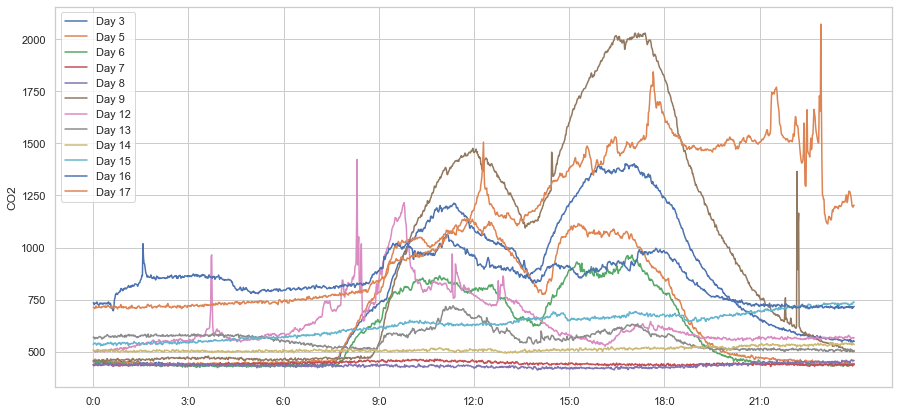

(9, 1440)


In [4]:
# per matrix profile invece usa la time series completa

# trasformazione dataset per le shaplets
ts3 = df.loc[df['day'] == 3] #martedì 4 febbraio
ts5 = df.loc[df['day'] == 5] #giovedì 5 febbraio
ts6 = df.loc[df['day'] == 6] # ...
ts7 = df.loc[df['day'] == 7] #weekend
ts8 = df.loc[df['day'] == 8] #weekend
ts9 = df.loc[df['day'] == 9] # primo salto temporale (interruzione delle registrazioni nei giorni 10 e 11)
ts12 = df.loc[df['day'] == 12]
ts13 = df.loc[df['day'] == 13]
ts14 = df.loc[df['day'] == 14] #weekend
ts15 = df.loc[df['day'] == 15] #weekend
ts16 = df.loc[df['day'] == 16]
ts17 = df.loc[df['day'] == 17]


ts3 = create_time_index(ts3)
ts5 = create_time_index(ts5)
ts6 = create_time_index(ts6)
ts7 = create_time_index(ts7)
ts8 = create_time_index(ts8)
ts9 = create_time_index(ts9)
ts12 = create_time_index(ts12)
ts13 = create_time_index(ts13)
ts14 = create_time_index(ts14)
ts15 = create_time_index(ts15)
ts16 = create_time_index(ts16)
ts17 = create_time_index(ts17)

variable = 'CO2'

plt.figure(figsize=(15,7))
ts3 = ts3[variable]
ts5 = ts5[variable]
ts6 = ts6[variable]
ts7 = ts7[variable]
ts8 = ts8[variable]
ts9 = ts9[variable]
ts12 = ts12[variable]
ts13 = ts13[variable]
ts14 = ts14[variable]
ts15 = ts15[variable]
ts16 = ts16[variable]
ts17 = ts17[variable]


sns.set(style = 'whitegrid')
plt.ylabel(variable)
plt.plot(ts3)
plt.plot(ts5)
plt.plot(ts6)
plt.plot(ts7)
plt.plot(ts8)
plt.plot(ts9)
plt.plot(ts12)
plt.plot(ts13)
plt.plot(ts14)
plt.plot(ts15)
plt.plot(ts16)
plt.plot(ts17)
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.show()


"""
L'algoritmo Shapelet discovery richiede un training e un test. Abbiamo diviso il dataset in giorni completi (senza gap),
per un totale di 12 giorni, e suddiviso questi giorni in training e test set (9 e 3 ts ciascuno).
La variabile da predirre è 'weekend', perché ci è sembrato il modo più ragionevole di associare a ogni time series
giornaliera un unico valore numerico da predire.
"""
X_train = np.array([ts3, ts5, ts6, ts7, ts8, ts9, ts12, ts13, ts14])
X_test = np.array([ts15, ts16, ts17])
print(X_train.shape) # 12 ts di lunghezza 1440
# Creiamo a mano i il test set in base ai valori di weekend (durante il weekend l'ufficio non è occupato)
# weekend = 1 -----> Occupancy = 0
#                   3, 5, 6, 7, 8, 9, 12, 13, 14, 
y_train = np.array([0, 0, 0, 1, 1, 0, 0,  0,  1])
#                  15, 16, 17
y_test = np.array([1,  0,  0])

In [5]:
X_train[0]

array([451.5 , 455.25, 455.25, ..., 551.5 , 554.  , 550.  ])

# Shapelet Discovery

In [7]:
n_ts, ts_sz = X_train.shape
#n_classes = len(set(y))
n_classes = len(set(y_train))
# Set the number of shapelets per size as done in the original paper
# correct number of the shapelet size (3)
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.2,
                                                       r=1)
"""
This Retruns:
per ogni lunghezza di una shapelet, il numero di shapelet da generare
"""

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 9
ts_sz 1440
n_classes 2
shapelet_sizes {288: 4}


In [8]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes, optimizer='sgd',
                        weight_regularizer=0.01,
                        max_iter=200, verbose=1, random_state=2)

In [9]:
shp_clf.fit(X_train, y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node false_conv_0_0/convolution}}]]
	 [[Mean/_95]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node false_conv_0_0/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
predicted_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))

In [ ]:
print(y_test)
print(predicted_labels)

In [ ]:
# find and visualize the shapelet, more importante than the class predicted
predicted_locations = shp_clf.locate(X_train)

In [ ]:
ts_id = 0
plt.figure(figsize=(15, 5))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "({} shapelets extracted)".format(n_shapelets))

plt.plot(X_train[ts_id].ravel())
plt.plot(ts3, color='slategrey', lw=2, alpha = 0.90) # uguali, corrisponde al giorno 3 (martedì)
plt.xticks(range(0, 1440, 180))
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

# Matrix Profile

Documentazione

https://github.com/target/matrixprofile-ts

https://github.com/TDAmeritrade/stumpy

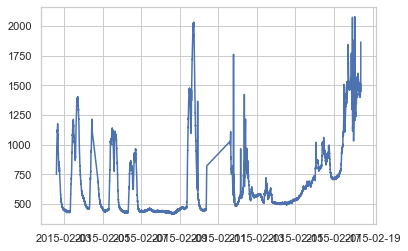

In [6]:
ts = df['CO2']
plt.plot(ts)

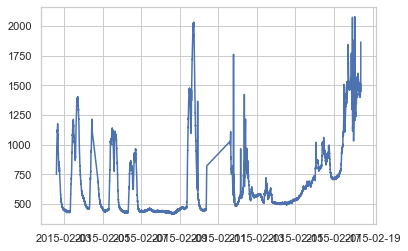

In [7]:
plt.plot(ts)
plt.show()

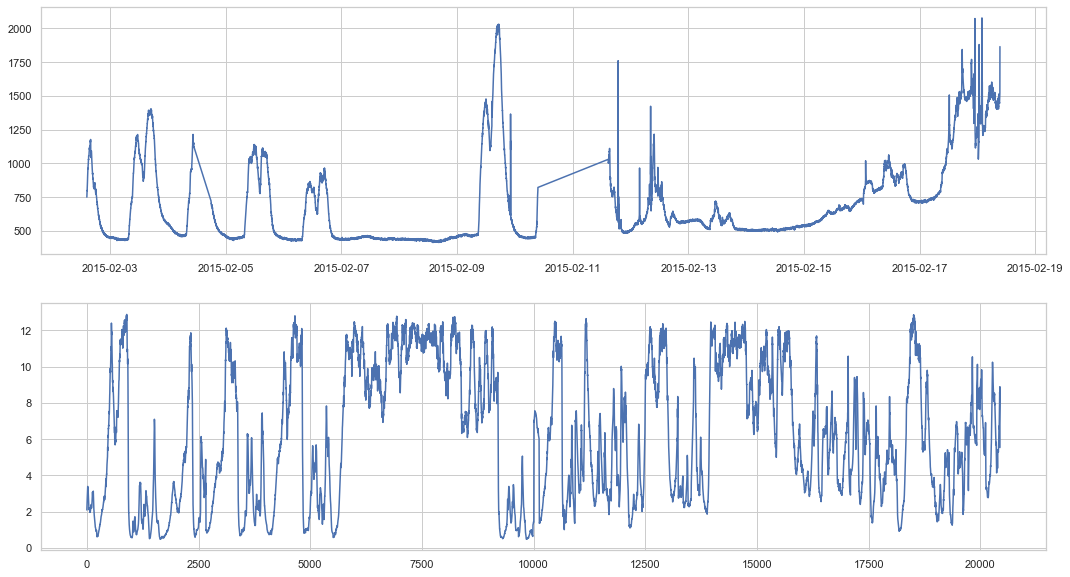

In [8]:
w = 120
mp, mpi = matrixProfile.stomp(ts.values, w)

plt.figure(figsize=(18, 10))
plt.subplot2grid((2,1), (0,0))
plt.plot(ts)

plt.subplot2grid((2,1), (1,0))
plt.plot(mp)
plt.show()

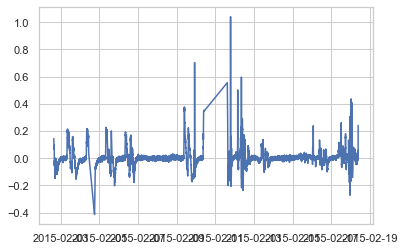

In [9]:
window = 60
ts_log_mov_diff = pd.Series(np.log(ts) - np.log(ts).rolling(window, center=False).mean(), index=ts.index)

plt.plot(ts_log_mov_diff)
plt.show()

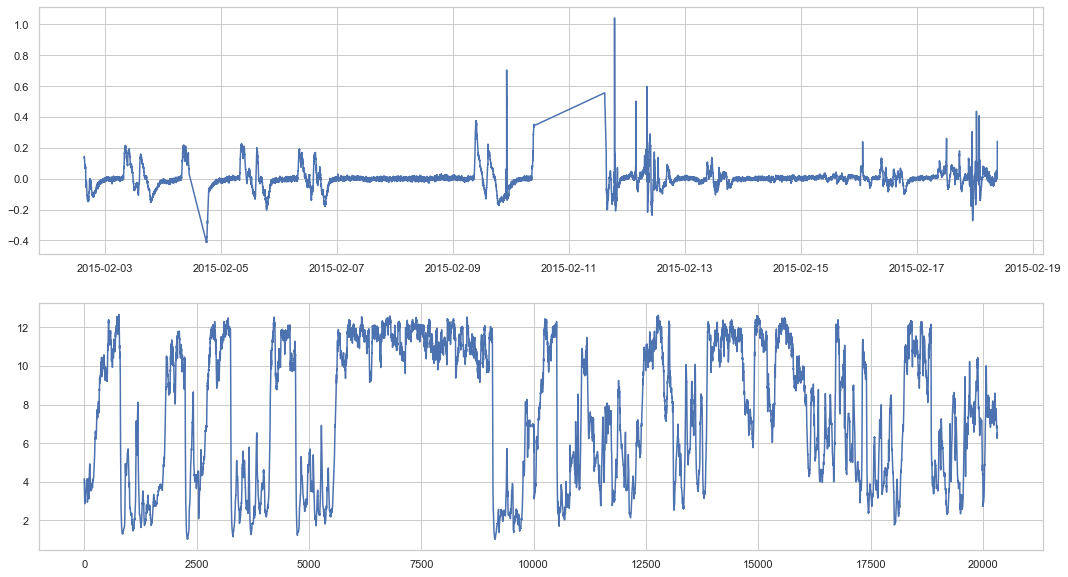

In [10]:
mp, mpi = matrixProfile.stomp(ts_log_mov_diff.values[w-1:], w)

# mp: matrix profile
# mpi: matrix profile index

plt.figure(figsize=(18, 10))
plt.subplot2grid((2,1), (0,0))
plt.plot(ts_log_mov_diff)

plt.subplot2grid((2,1), (1,0))
plt.plot(mp)
plt.show()

# Motif Discovery

In [11]:
#mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=5)

Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.

Returns
The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [12]:
mo

[[852, 2295, 3307, 4751, 9139], [1342, 9559], [1085, 9692], [10569, 17450]]

In [13]:
mod

[1.0272629463709941, 1.3683672503205242, 1.450416481484989, 1.6921398374167065]

In [14]:
ts.values

array([ 749.2       ,  760.4       ,  769.66666667, ..., 1521.5       ,
       1632.        , 1864.        ])

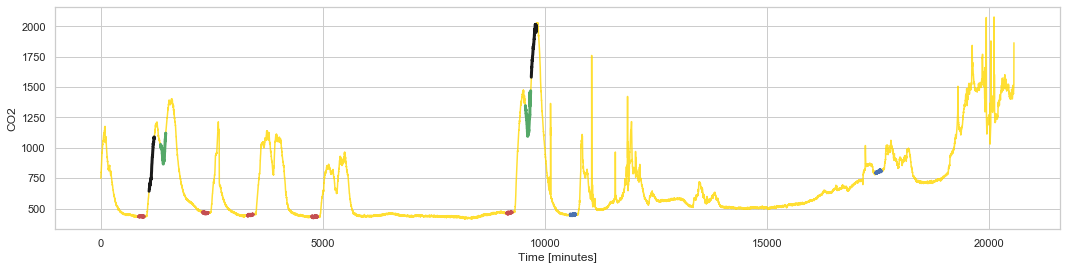

'\nparte sinistra: molti più motif rispetto a quella destra. Da notare che la prima metà sono osservazione con la porta chiusa,\ne la seconda con porta aperta. Ipotizziamo che aprire la porta, per quanto riguarda CO2, abbia influenzato negativamente\nil pattern regolare che aveva CO2 quando la porta era chiusa. Infatti Quasi tutti i motif sono stati trovati con la porta chiusa.\n'

In [18]:
#plt.figure(figsize=(18, 10))
#plt.subplot2grid((2,1), (0,0))
#plt.plot(mp, color='purple')

plt.figure(figsize = (18, 9))
plt.subplot2grid((2,1), (1,0))
plt.plot(ts.values, color='gold', alpha=0.80)
plt.ylabel("CO2")
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.xlabel("Time [minutes]")
plt.show()

"""
parte sinistra: molti più motif rispetto a quella destra. Da notare che la prima metà sono osservazione con la porta chiusa,
e la seconda con porta aperta. Ipotizziamo che aprire la porta, per quanto riguarda CO2, abbia influenzato negativamente
il pattern regolare che aveva CO2 quando la porta era chiusa. Infatti Quasi tutti i motif sono stati trovati con la porta chiusa.
"""

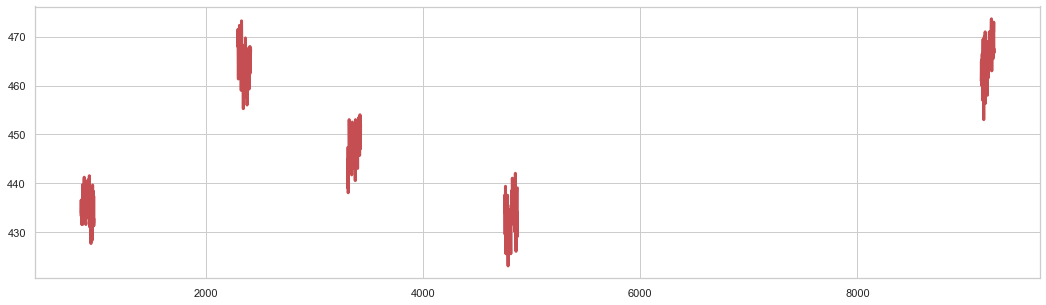

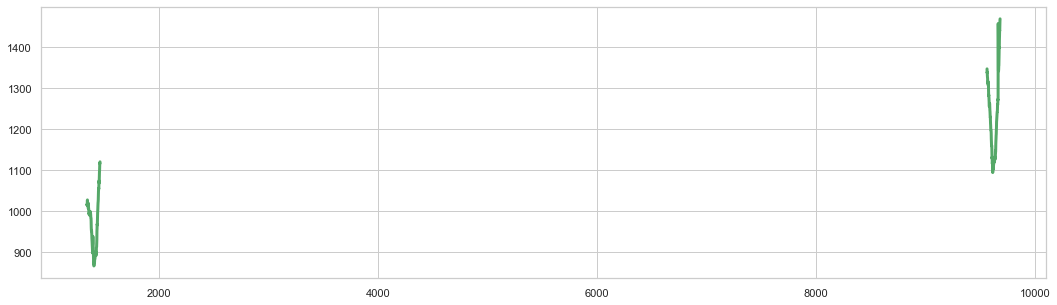

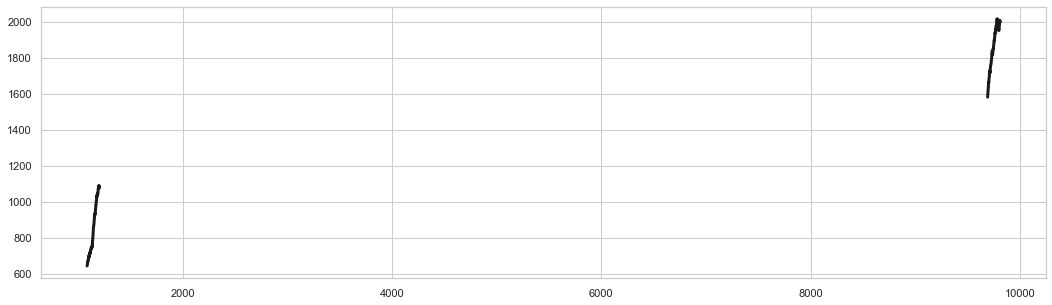

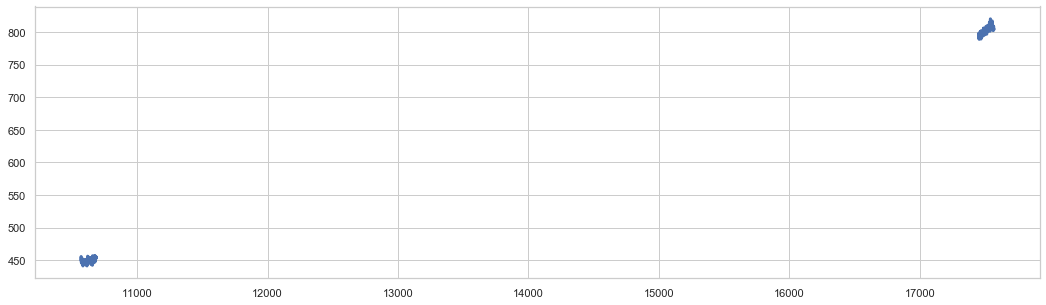

In [24]:
for m, d, c in zip(mo, mod, colors):
    plt.figure(figsize=(18, 5))
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

# Anomaly Discovery

In [25]:
help(discords)

Help on function discords in module matrixprofile.discords:

discords(mp, ex_zone, k=3)
    Computes the top k discords from a matrix profile
    
    Parameters
    ----------
    mp: matrix profile numpy array
    k: the number of discords to discover
    ex_zone: the number of samples to exclude and set to Inf on either side of a found discord
    
    Returns a list of indexes represent the discord starting locations. MaxInt indicates there
    were no more discords that could be found due to too many exclusions or profile being too
    small. Discord start indices are sorted by highest matrix profile value.



In [26]:
anoms = discords(mp, ex_zone=2, k=5)

In [27]:
anoms

array([  769,   771, 12776, 14976, 14978])

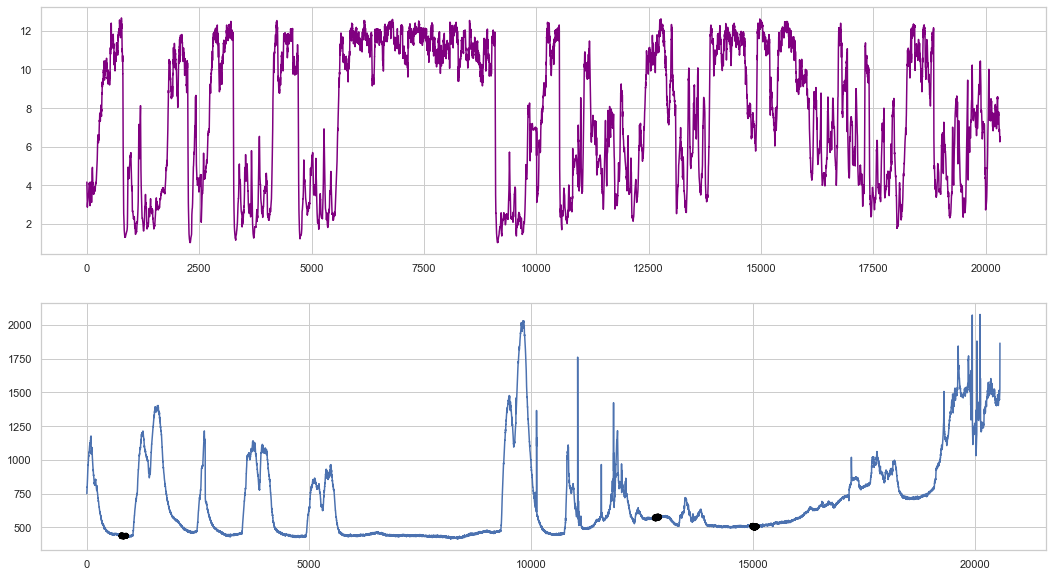

In [28]:
plt.figure(figsize=(18, 10))
plt.subplot2grid((2,1), (0,0))
plt.plot(mp, color='purple')
plt.subplot2grid((2,1), (1,0))
plt.plot(ts.values)
colors = ['black', 'black', 'black', 'black', 'black'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = ts.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=5)

